The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==1.0.3


# The Bahdanau Attention Mechanism
:label:`sec_seq2seq_attention`

When we encountered machine translation in :numref:`sec_seq2seq`,
we designed an encoder--decoder architecture for sequence-to-sequence learning
based on two RNNs :cite:`Sutskever.Vinyals.Le.2014`.
Specifically, the RNN encoder transforms a variable-length sequence
into a *fixed-shape* context variable.
Then, the RNN decoder generates the output (target) sequence token by token
based on the generated tokens and the context variable.

Recall :numref:`fig_seq2seq_details` which we repeat (:numref:`fig_s2s_attention_state`) with some additional detail. Conventionally, in an RNN all relevant information about a source sequence is translated into some internal *fixed-dimensional* state representation by the encoder. It is this very state that is used by the decoder as the complete and exclusive source of information for generating the translated sequence. In other words, the sequence-to-sequence mechanism treats the intermediate state as a sufficient statistic of whatever string might have served as input.

![Sequence-to-sequence model. The state, as generated by the encoder, is the only piece of information shared between the encoder and the decoder.](../img/seq2seq-state.svg)
:label:`fig_s2s_attention_state`

While this is quite reasonable for short sequences, it is clear that it is infeasible for long ones, such as a book chapter or even just a very long sentence. After all, before too long there will simply not be enough "space" in the intermediate representation to store all that is important in the source sequence. Consequently the decoder will fail to translate long and complex sentences. One of the first to encounter this was :citet:`Graves.2013` who tried to design an RNN to generate handwritten text. Since the source text has arbitrary length they designed a differentiable attention model
to align text characters with the much longer pen trace,
where the alignment moves only in one direction. This, in turn, draws on decoding algorithms in speech recognition, e.g., hidden Markov models :cite:`rabiner1993fundamentals`.

Inspired by the idea of learning to align,
:citet:`Bahdanau.Cho.Bengio.2014` proposed a differentiable attention model
*without* the unidirectional alignment limitation.
When predicting a token,
if not all the input tokens are relevant,
the model aligns (or attends)
only to parts of the input sequence
that are deemed relevant to the current prediction. This is then used to update the current state before generating the next token. While quite innocuous in its description, this *Bahdanau attention mechanism* has arguably turned into one of the most influential ideas of the past decade in deep learning, giving rise to Transformers :cite:`Vaswani.Shazeer.Parmar.ea.2017` and many related new architectures.


In [1]:
import torch
from torch import nn
from d2l import torch as d2l

## Model

We follow the notation introduced by the sequence-to-sequence architecture of :numref:`sec_seq2seq`, in particular :eqref:`eq_seq2seq_s_t`.
The key idea is that instead of keeping the state,
i.e., the context variable $\mathbf{c}$ summarizing the source sentence, as fixed, we dynamically update it, as a function of both the original text (encoder hidden states $\mathbf{h}_{t}$) and the text that was already generated (decoder hidden states $\mathbf{s}_{t'-1}$). This yields $\mathbf{c}_{t'}$, which is updated after any decoding time step $t'$. Suppose that the input sequence is of length $T$. In this case the context variable is the output of attention pooling:

$$\mathbf{c}_{t'} = \sum_{t=1}^{T} \alpha(\mathbf{s}_{t' - 1}, \mathbf{h}_{t}) \mathbf{h}_{t}.$$

We used $\mathbf{s}_{t' - 1}$ as the query, and
$\mathbf{h}_{t}$ as both the key and the value. Note that $\mathbf{c}_{t'}$ is then used to generate the state $\mathbf{s}_{t'}$ and to generate a new token: see :eqref:`eq_seq2seq_s_t`. In particular, the attention weight $\alpha$ is computed as in :eqref:`eq_attn-scoring-alpha`
using the additive attention scoring function
defined by :eqref:`eq_additive-attn`.
This RNN encoder--decoder architecture
using attention is depicted in :numref:`fig_s2s_attention_details`. Note that later this model was modified so as to include the already generated tokens in the decoder as further context (i.e., the attention sum does not stop at $T$ but rather it proceeds up to $t'-1$). For instance, see :citet:`chan2015listen` for a description of this strategy, as applied to speech recognition.

![Layers in an RNN encoder--decoder model with the Bahdanau attention mechanism.](../img/seq2seq-details-attention.svg)
:label:`fig_s2s_attention_details`

## Defining the Decoder with Attention

To implement the RNN encoder--decoder with attention,
we only need to redefine the decoder (omitting the generated symbols from the attention function simplifies the design). Let's begin with [**the base interface for decoders with attention**] by defining the quite unsurprisingly named `AttentionDecoder` class.


In [2]:
class AttentionDecoder(d2l.Decoder):  #@save
    """The base attention-based decoder interface."""
    def __init__(self):
        super().__init__()

    @property
    def attention_weights(self):
        raise NotImplementedError

We need to [**implement the RNN decoder**]
in the `Seq2SeqAttentionDecoder` class.
The state of the decoder is initialized with
(i) the hidden states of the last layer of the encoder at all time steps, used as keys and values for attention;
(ii) the hidden state of the encoder at all layers at the final time step, which serves to initialize the hidden state of the decoder;
and (iii) the valid length of the encoder, to exclude the padding tokens in attention pooling.
At each decoding time step, the hidden state of the final layer of the decoder, obtained at the previous time step, is used as the query of the attention mechanism.
Both the output of the attention mechanism and the input embedding are concatenated to serve as the input of the RNN decoder.


In [3]:
class Seq2SeqAttentionDecoder(AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.attention = d2l.AdditiveAttention(num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(
            embed_size + num_hiddens, num_hiddens, num_layers,
            dropout=dropout)
        self.dense = nn.LazyLinear(vocab_size)
        self.apply(d2l.init_seq2seq)

    def init_state(self, enc_outputs, enc_valid_lens):
        # Shape of outputs: (num_steps, batch_size, num_hiddens).
        # Shape of hidden_state: (num_layers, batch_size, num_hiddens)
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)

    def forward(self, X, state):
        # Shape of enc_outputs: (batch_size, num_steps, num_hiddens).
        # Shape of hidden_state: (num_layers, batch_size, num_hiddens)
        enc_outputs, hidden_state, enc_valid_lens = state
        # Shape of the output X: (num_steps, batch_size, embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        for x in X:
            # Shape of query: (batch_size, 1, num_hiddens)
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            # Shape of context: (batch_size, 1, num_hiddens)
            context = self.attention(
                query, enc_outputs, enc_outputs, enc_valid_lens)
            # Concatenate on the feature dimension
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            # Reshape x as (1, batch_size, embed_size + num_hiddens)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        # After fully connected layer transformation, shape of outputs:
        # (num_steps, batch_size, vocab_size)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state,
                                          enc_valid_lens]

    @property
    def attention_weights(self):
        return self._attention_weights

In the following, we [**test the implemented
decoder**] with attention
using a minibatch of four sequences, each of which are seven time steps long.


In [4]:
vocab_size, embed_size, num_hiddens, num_layers = 10, 8, 16, 2
batch_size, num_steps = 4, 7
encoder = d2l.Seq2SeqEncoder(vocab_size, embed_size, num_hiddens, num_layers)
decoder = Seq2SeqAttentionDecoder(vocab_size, embed_size, num_hiddens,
                                  num_layers)
X = torch.zeros((batch_size, num_steps), dtype=torch.long)
state = decoder.init_state(encoder(X), None)
output, state = decoder(X, state)
d2l.check_shape(output, (batch_size, num_steps, vocab_size))
d2l.check_shape(state[0], (batch_size, num_steps, num_hiddens))
d2l.check_shape(state[1][0], (batch_size, num_hiddens))

## [**Training**]

Now that we specified the new decoder we can proceed analogously to :numref:`sec_seq2seq_training`:
specify the hyperparameters, instantiate
a regular encoder and a decoder with attention,
and train this model for machine translation.


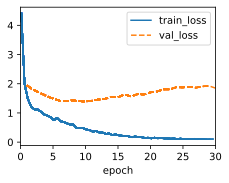

In [5]:
data = d2l.MTFraEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
encoder = d2l.Seq2SeqEncoder(
    len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(
    len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = d2l.Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                    lr=0.005)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

After the model is trained,
we use it to [**translate a few English sentences**]
into French and compute their BLEU scores.


In [6]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{d2l.bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['il', 'court', '.'], bleu,0.000
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


Let's [**visualize the attention weights**]
when translating the last English sentence.
We see that each query assigns non-uniform weights
over key--value pairs.
It shows that at each decoding step,
different parts of the input sequences
are selectively aggregated in the attention pooling.


In [7]:
_, dec_attention_weights = model.predict_step(
    data.build([engs[-1]], [fras[-1]]), d2l.try_gpu(), data.num_steps, True)
attention_weights = torch.cat(
    [step[0][0][0] for step in dec_attention_weights], 0)
attention_weights = attention_weights.reshape((1, 1, -1, data.num_steps))

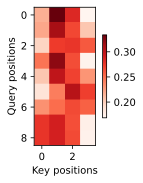

In [8]:
# Plus one to include the end-of-sequence token
d2l.show_heatmaps(
    attention_weights[:, :, :, :len(engs[-1].split()) + 1].cpu(),
    xlabel='Key positions', ylabel='Query positions')

## Summary

When predicting a token, if not all the input tokens are relevant, the RNN encoder--decoder with the Bahdanau attention mechanism selectively aggregates different parts of the input sequence. This is achieved by treating the state (context variable) as an output of additive attention pooling.
In the RNN encoder--decoder, the Bahdanau attention mechanism treats the decoder hidden state at the previous time step as the query, and the encoder hidden states at all the time steps as both the keys and values.


## Exercises

1. Replace GRU with LSTM in the experiment.
1. Modify the experiment to replace the additive attention scoring function with the scaled dot-product. How does it influence the training efficiency?


[Discussions](https://discuss.d2l.ai/t/1065)
